# Exercise 5

## Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14
from scipy.stats       import special_ortho_group
from itertools import product

# manifold.TSNE
from sklearn.cluster import DBSCAN
from collections import OrderedDict
from sklearn           import manifold  #, datasets
from sklearn.neighbors import NearestNeighbors
from time              import time
from sklearn.cluster import DBSCAN
from   tqdm       import tqdm
import seaborn    as sns
import pandas     as pd
from pylab import cm
import warnings
warnings.filterwarnings("ignore")

## Functions

In [78]:
mycmap  = ListedColormap(["blue","red","gold"])

cmap = cm.get_cmap('plasma', 6)  # matplotlib color palette name, n colors
cpalette = ["blue","red","gold","orange", 
            "#006FA6", "#A30059", "#0000A6", 
            "#63FFAC","#B79762", "#004D43",
            "#8FB0FF", "#997D87","#5A0007", 
            "#809693","#1B4400", "#4FC601", 
            "#3B5DFF", "#4A3B53","#886F4C",
            "#34362D", "#B4A8BD", "#00A6AA",
            "#452C2C","#636375", "#A3C8C9", 
            "#FF913F", "#938A81","#575329", 
            "#00FECF", "#B05B6F"]

point_size = 15

def plot_tSNE(Y,ax,*,title = "", dim2 = True):
    """plot a t-SNE fit result to the axis and formats the axis

    Parameters
    ----------
    Y : np.darray
        the result from TSNE fit_transform, two or three dim array of points locations
    ax : matplotlib.axis
        the axis to plot the result to
    title : str, optional
        the tilte of the plot, by default ""
    dim2 : bool, optional
        toggle 2D(True) or 3D(False) ploting, by default True
    """
    if dim2:
        ax.set_title(title)
        ax.scatter(Y[:, 0], Y[:, 1], s = point_size, c=y,cmap=mycmap, marker = 'o')
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
    else:
        ax.set_title(title)
        ax.scatter(Y[:,0], Y[:,1],Y[:,2], s=30, c=y, depthshade=True, cmap=mycmap, marker = 'o')
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.zaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        if yu == -1:
            ax.scatter(X[pos,0], X[pos,1], c='k', s = point_size, marker = "x")
        else:
            ax.scatter(X[pos,0], X[pos,1], c=cpalette[i%len(cpalette)], s= point_size, marker = "o")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

In [79]:
#from sklearn.datasets import make_blobs
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]


def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

## Load data

N= 1000   D= 3


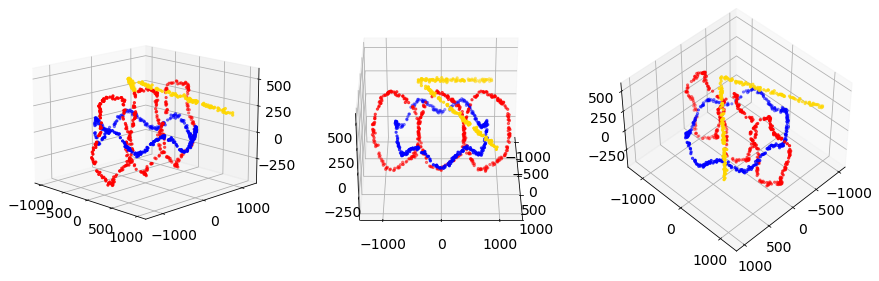

In [35]:
#fname,fnamey="x_def_3d.dat","y_def_3d.dat"
fname,fnamey="x_3d.dat","y_3d.dat"
data= np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)


fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(data[:,0], data[:,1],data[:,2], s=5, c=y, depthshade=True, cmap=mycmap)
    ax.view_init(15+15*i, 45*(i-1))
plt.show()

# 1 Role of dimensions

In [38]:
def increase_dimension(x : np.ndarray , L : int, *, noise_size = 100, rotate = False):
    
    """returns new x with noise added in the L extra dimensions

    Parameters
    ----------
    x : np.ndarray
        the original data
    L : int
        number of dimensions to add
    noise_size : int, optional
        the size of the noise draw from a unifor distribution, by default 10
    rotate : bool, optional
        toggle if the data should be rotated, by default False

    Returns
    -------
    x_increse : np.ndarray
        the data with the extra L dimensions
    """
    x_increase = np.random.normal(loc = 0, scale= noise_size, size = (x.shape[0], x.shape[1] + L) )
    x_increase[:,0:x.shape[1]] = x
    if rotate:
        x_increase = x_increase@special_ortho_group.rvs( x.shape[1] + L)
    return x_increase

## Increasing dimensions (without rotating)

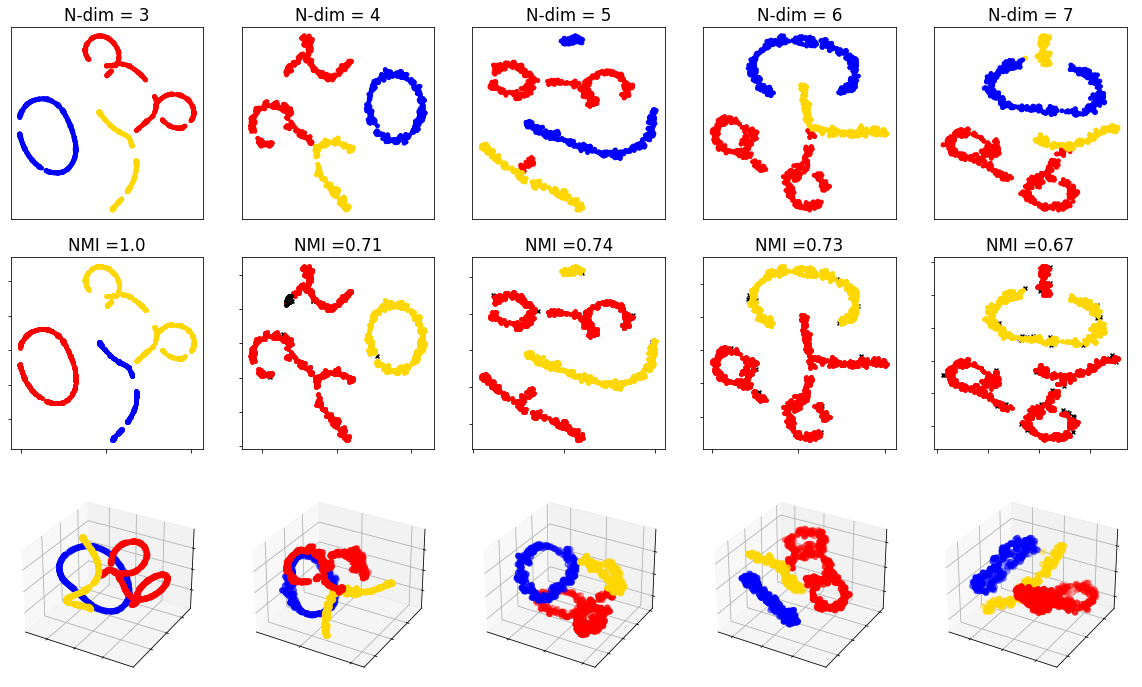

In [83]:
np.random.seed(0)
n_samples = N
max_dim = 5
dims = range(max_dim)
eps_values = [110, 170, 210, 230, 240]
min_samples_values = [4, 7, 7, 4, 4]


# (fig, axs) = plt.subplots(3 ,max_dim , figsize=(3*max_dim, 2*2.7))
fig = plt.figure(figsize=(4*max_dim, 3*4))

for i, (dim, eps, min_samples) in enumerate(zip(dims,eps_values, min_samples_values)) :
    
    tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity= 20)
    

    data_increase = increase_dimension(data, dim)

    ax = fig.add_subplot(3,max_dim, i+1)

    Y = tsne.fit_transform(data_increase)
    plot_tSNE(Y, ax, title = f"N-dim = {dim+3}")

    ax = fig.add_subplot(3,max_dim, max_dim + i+1)
 
    model = DBSCAN(eps= eps , min_samples= min_samples )
    model.fit(data_increase)
    y_pred = model.labels_
    nmi = NMI(y, y_pred)

    plotting_ax(Y,y_pred,ax)
    # ax[i].axis("off")
    ax.set_title(f"NMI ={round(nmi,2)}")

    ax = fig.add_subplot(3,max_dim, 2*max_dim + i +1, projection = '3d')

    tsne = manifold.TSNE(n_components = 3, init='random',
                         random_state=0, perplexity= 20)

    Y = tsne.fit_transform(data_increase)
    plot_tSNE(Y, ax, dim2= False)

plt.show()

## Increasing dimensions with rotating

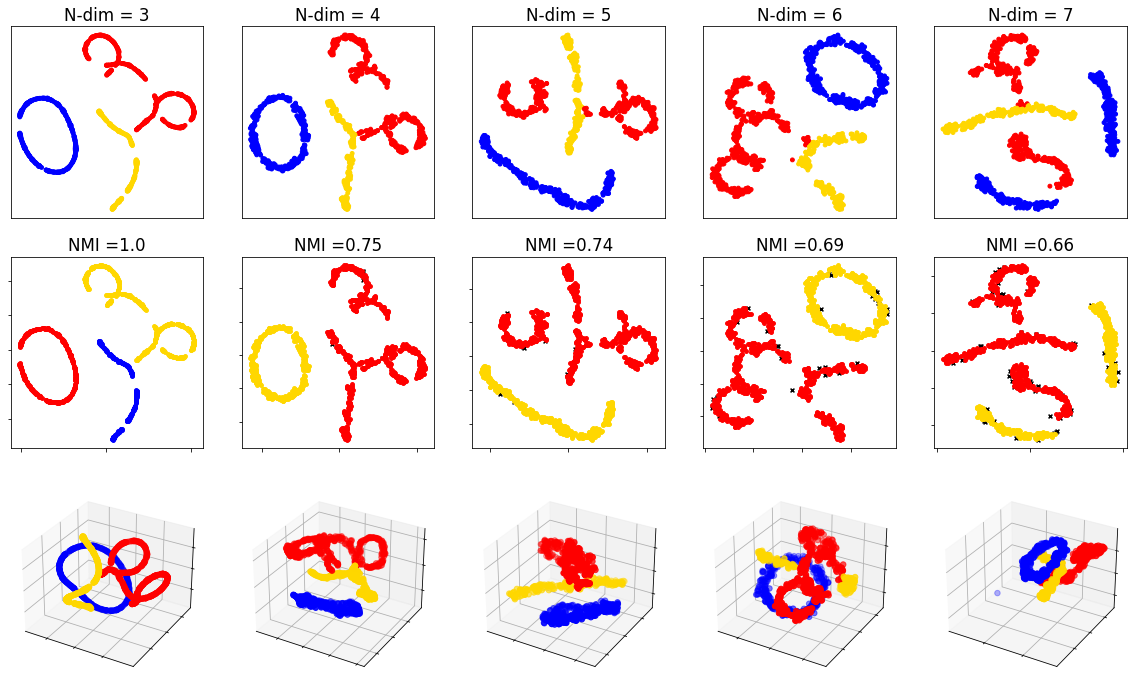

In [84]:
np.random.seed(0)
n_samples = N
max_dim = 5
dims = range(max_dim)
eps_values = [110, 170, 210, 230, 240]
min_samples_values = [4, 7, 7, 4, 4]


# (fig, axs) = plt.subplots(3 ,max_dim , figsize=(3*max_dim, 2*2.7))
fig = plt.figure(figsize=(4*max_dim, 3*4))

for i, (dim, eps, min_samples) in enumerate(zip(dims,eps_values, min_samples_values)) :
    
    tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity= 20)
    

    data_increase = increase_dimension(data, dim, rotate= True)

    ax = fig.add_subplot(3,max_dim, i+1)

    Y = tsne.fit_transform(data_increase)
    plot_tSNE(Y, ax, title = f"N-dim = {dim+3}")

    ax = fig.add_subplot(3,max_dim, max_dim + i+1)
 
    model = DBSCAN(eps= eps , min_samples= min_samples )
    model.fit(data_increase)
    y_pred = model.labels_
    nmi = NMI(y, y_pred)

    plotting_ax(Y,y_pred,ax)
    # ax[i].axis("off")
    ax.set_title(f"NMI ={round(nmi,2)}")

    ax = fig.add_subplot(3,max_dim, 2*max_dim + i +1, projection = '3d')

    tsne = manifold.TSNE(n_components = 3, init='random',
                         random_state=0, perplexity= 20)

    Y = tsne.fit_transform(data_increase)
    plot_tSNE(Y, ax, dim2= False)

plt.show()

When increasing the dimension of the data, one can see that the tSNE-visualization starts to struggle, and it is not able to clearly separate the different data types in the plots. It shows that with increasing dimensionality, it is harder to see the connection between the separation of the data in the higher and lower dimensions. Rotating the data seems to actually make the tSNE perform better in the 4- and 5 dimensional case, while the performance for the higher dimensions stays about the same. Rotating the data with an orthonormal matrix preserves the distances between the points. As the tSNE preserves only small pairwise distances and local similarities in the higher dimensions, the rotation should not affect the performance of the vizualization too much, as long as the distances between points are preserved. Which is confirmed by the results.

# 2 The role of "perplexity" in t-SNE

The perplexity parameter in the t-SNE algorithm can effectively be viewed as the the number of close neighbours each point has. Thus for very low perplexity one only se that there is randomnes, but as it is increased paterns come out. Then agin for larger values start to merge together since the now they are also taken into account since the perplexity is so high. 

##  Varying Perplexity with random init

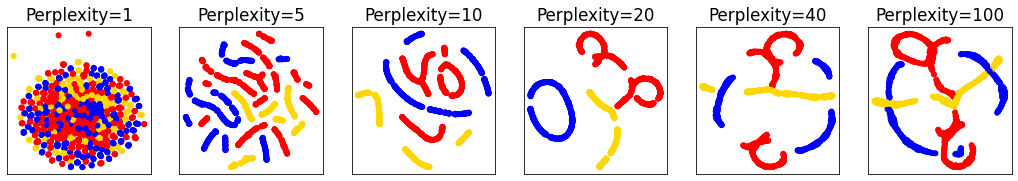

In [26]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [1, 5,10,20,40,100]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

for i, perplexity in enumerate(perplexities):
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)

    plot_tSNE(Y,subplots[i],title= "Perplexity=%d" % perplexity )
    
plt.show()

## Varying Perplexity with pca init

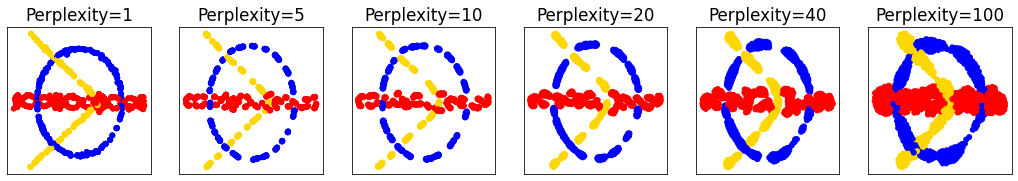

In [27]:
(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

for i, perplexity in enumerate(perplexities):
    tsne = manifold.TSNE(n_components=n_components, init='pca',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)

    plot_tSNE(Y,subplots[i],title= "Perplexity=%d" % perplexity )

If t-SNE is initialized by using principal component analysis we obtained different results. In particular, using PCA the z-component of each sample is neglected.

## Varying Perplexity with random init in 3D

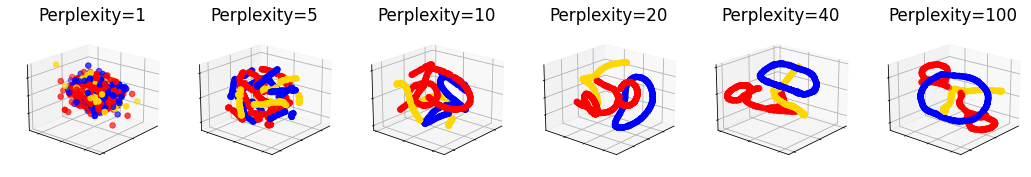

In [142]:
np.random.seed(0)
n_components = 2 

fig = plt.figure(figsize=(3*Np, 2.7))


for i, perplexity in enumerate(perplexities):
    tsne = manifold.TSNE(n_components=3, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    
    ax = fig.add_subplot(1,Np,i+1,projection='3d')
    ax.view_init(20, 40)
    plot_tSNE(Y,ax,title= "Perplexity=%d" % perplexity ,dim2= False )
    
plt.show()

## Varying Perplexity with pca init in 3D

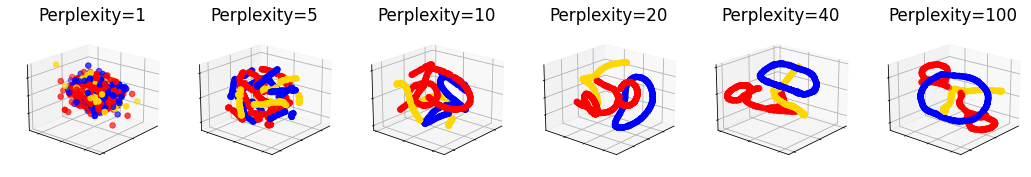

In [143]:
np.random.seed(20)
n_samples = N
n_components = 2 
perplexities = [1, 5,10,20,40,100]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])


fig = plt.figure(figsize=(3*Np, 2.7))


for i, perplexity in enumerate(perplexities):
    tsne = manifold.TSNE(n_components=3, init='pca',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    
    ax = fig.add_subplot(1,Np,i+1,projection='3d')
    ax.view_init(20, 40)
    plot_tSNE(Y,ax,title= "Perplexity=%d" % perplexity ,dim2= False )
    
plt.show()

## Animation of changing perplexity

In [117]:
from matplotlib.animation import FuncAnimation
from IPython import display

def animate(frame):
    tsne = manifold.TSNE(n_components=n_components, init='random',
                            random_state=0, perplexity=frame+1)

    Y = tsne.fit_transform(data)

    scatter.set_offsets(Y)

    ax.set_title(f"Perplexity = {frame+1}")
    ax.axis('tight')
    

fig,ax = plt.subplots()

ax.set_title("Perplexity=%d" % perplexity)

ax.tick_params(left=False,bottom=False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')


tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity= 1)
    
Y = tsne.fit_transform(data)


scatter = ax.scatter(Y[:,0], Y[:,1],c = y, cmap=mycmap)

anim = FuncAnimation(fig, 
    animate,
    frames = 80,
    interval = 250)

plt.close()
display.HTML(anim.to_jshtml())

The perplexity parameter in the tSNE method influences the variance of the gaussian distribution that is used on each point to find the densities of the surrounding points, and hence also a measure for the local similarities in the structure of the high dimensional space. Increasing the perplexity is therefore essentually to increase the amount of nearest neighbours, as one increses the gaussian searching circle. 

For very small perplexities one finds only randomness, while patterns starts to arise when it is increased. That means the method is able to find local similarities in the data. However, by making the perplexity very high, the patterns become infiltrated and merge together, as one start to look for similarities further and further away, and many data points are considered at once. Hence, one usually seek an intermediate optimal value, which usually depends on the datatype. Usually the range between perplexity is from 5 to 50. 

In our example one can see that patterns arise with perplexity equal to 5, and that it is fully separable at a perplexity of 20. However, with perplexity equal to 40 the patterns start to merge, and with a value of 100 the patterns is no longer separable.

When initializing the tSNE principal component analysis, we can see that the results become very different. In opposition to tSNE, principal analysis seek to preserve large pairwise distances to maximize the variance of the data. By this method, things that are different will end up far apart. As it is a linear reduction technique, it often doesn't work well with non-linear manifold structures, and does not preserve the structure of the data well. This is visible in the plots with pca as the different data types are not separable. It also explains why the shape of the pattern does not change much with increasing perplexity, as the number of nearest neighbours become irrelevant when the method only seeks to preserve large distances. One can see that the pattern actually resembles that achieved by the tSNE method if the perplexity is turned up to a value of 100, which is 2 times the normal maximal value used for the method. It shows that that the local similarities are important for the structure of the data.

(The 3D-plots shows change in perplexity in 3D also for principal analysis, which is a bit weird. They seem to be the same plots as for the case with random initialization, which could be an error somewhere. Can't find one though!)

# 3 Tunin "eps" and "minPts" in DBSCAN

In [54]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
y_true = y
mean_min_dist = 20

def DBSCAN_predict(x : np.ndarray, extra_dim= 0, **kwargs):
    """predicts the labels from DBScan with parameters in kwargs first changing x based on extra_dim and rotate

    Parameters
    ----------
    x : np.ndarray
        original data to cluster
    extra_dim : int, optional
        placeholder to catch keyword so not passed to DBScan

    Returns
    -------
    y_predict : np.ndarray
        the predicted labels from DBScan
    """
    
    model = DBSCAN(**kwargs)
    model.fit(x)
    y_predict = np.copy(model.labels_)
    return y_predict

def make_kwdict(config_dict):
    result = product(*config_dict.values())
    kw_dict = {}
    for i,args in enumerate(result):
        kw_dict[i] = {
            list(config_dict.keys())[j] : args[j] for j in range(len(args))
        }
    return kw_dict




eps_range = range(10, 300, 10)
min_samples_range = range(1,50,1)
extra_dim_range = range(0,max_dim,1)
config_dict = {
    "eps" : eps_range,
    "min_samples" : min_samples_range,
    "extra_dim" : extra_dim_range
}

x_sets = {
    extra_dim : increase_dimension(data ,extra_dim, ) for extra_dim in extra_dim_range
}

kw_dicts = make_kwdict(config_dict)

# DBScan with several parameters
nmis = []
for kw_dict in tqdm(kw_dicts.values()):
    x = x_sets[kw_dict["extra_dim"]]

    y_hat = DBSCAN_predict(x, **kw_dict)
    nmi = NMI(y_hat, y_true)
    nmis.append(nmi)

# Convert to dataframe for seaborn
nmis = np.array(nmis)
df = pd.DataFrame(kw_dicts)
df = df.transpose()
df["nmi"] = nmis

100%|██████████| 7105/7105 [01:28<00:00, 80.21it/s] 


## Normal data

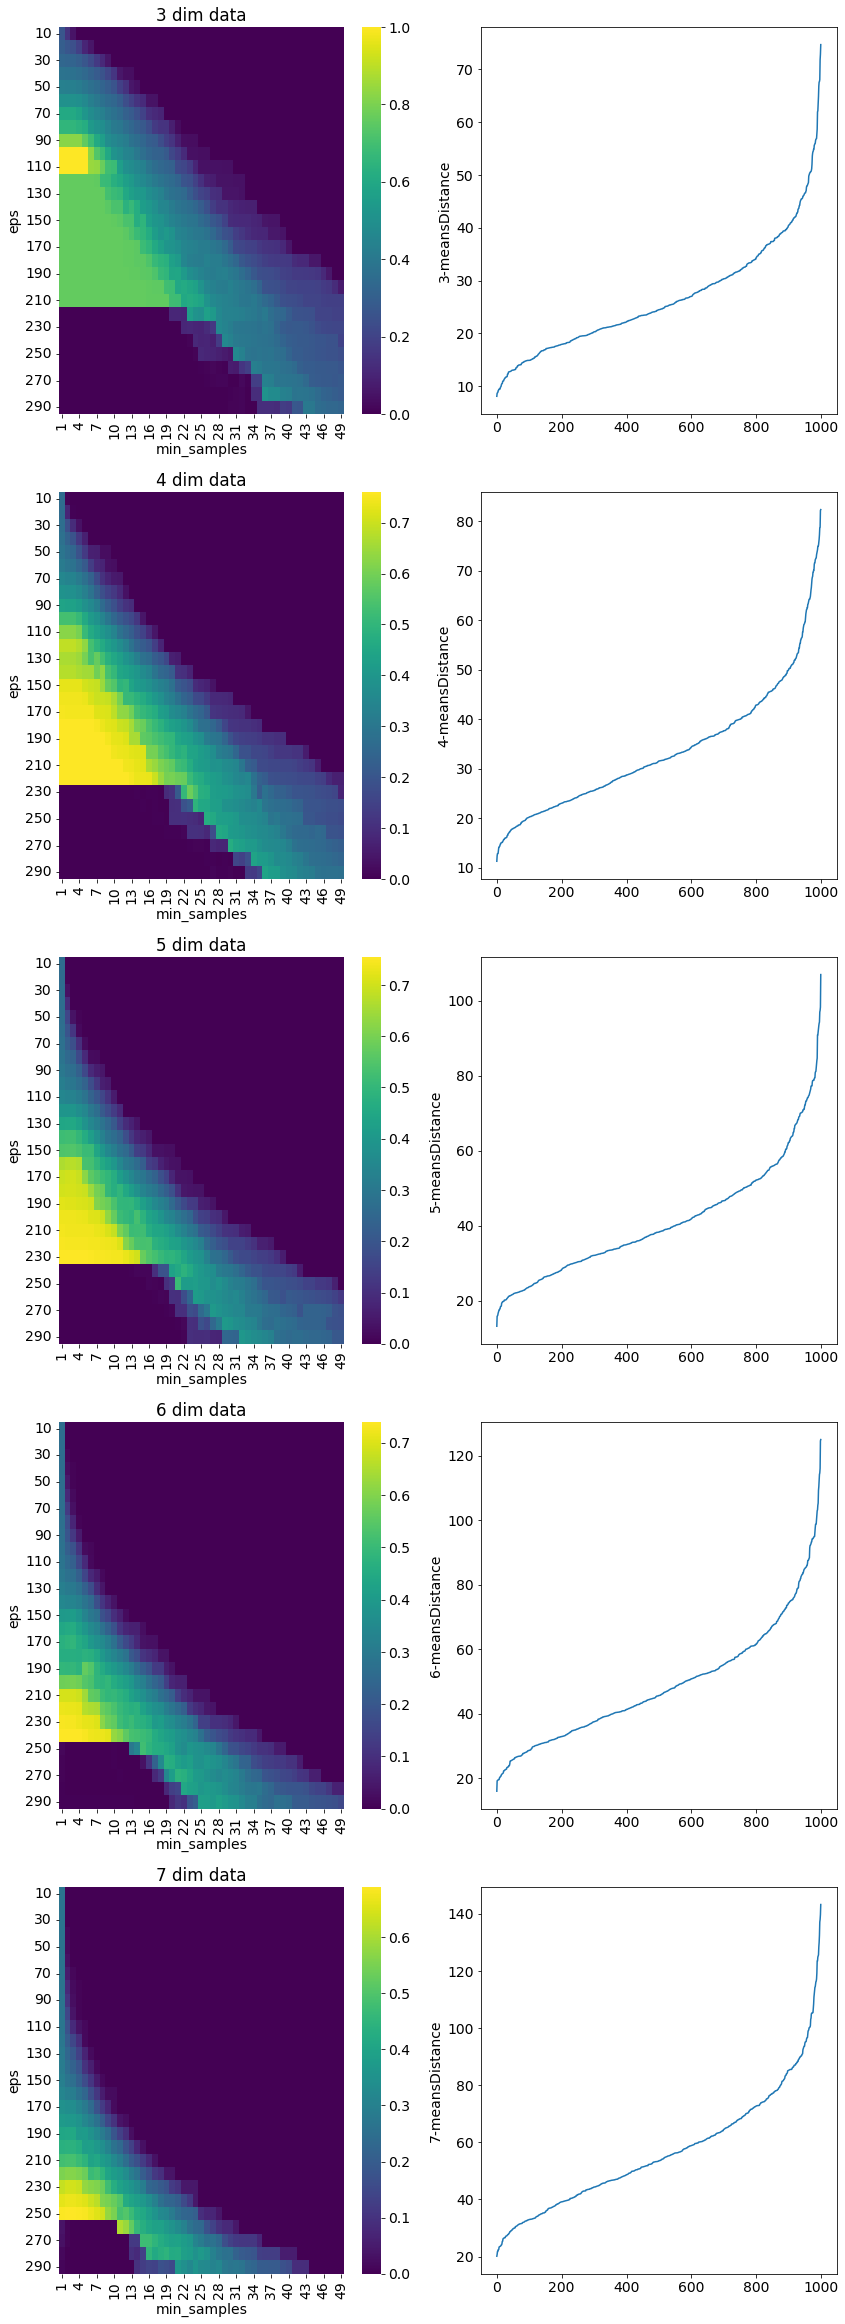

In [61]:
fig, axs = plt.subplots(len(extra_dim_range),2, figsize = (12, len(extra_dim_range)*6.5))

for extra_dim,ax in zip(extra_dim_range, axs) :
    df_dim = df[df["extra_dim"] == extra_dim]

    df_dim_plot = df_dim.pivot_table("nmi","eps","min_samples")
    sns.heatmap(df_dim_plot, cmap = 'viridis', ax = ax[0])
    
    ax[0].set_title(f"{3+extra_dim} dim data")
    
    neighbors = NearestNeighbors(n_neighbors=20)
    neighbors_fit = neighbors.fit(data)
    
    distances, indices = neighbors_fit.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,extra_dim+2]

    ax[1].plot(distances)
    ax[1].set_ylabel(f"{extra_dim+3}-meansDistance")
plt.tight_layout()
plt.show()

## Rotated data

In [62]:
x_sets_rot = {
    extra_dim : increase_dimension(data ,extra_dim,rotate= True ) for extra_dim in extra_dim_range
}
nmis = []
for kw_dict in tqdm(kw_dicts.values()):
    x = x_sets_rot[kw_dict["extra_dim"]]

    y_hat = DBSCAN_predict(x, **kw_dict)
    nmi = NMI(y_hat, y_true)
    nmis.append(nmi)

# Convert to dataframe for seaborn
nmis = np.array(nmis)
df_rot = pd.DataFrame(kw_dicts)
df_rot = df_rot.transpose()
df_rot["nmi"] = nmis

100%|██████████| 7105/7105 [01:30<00:00, 78.89it/s] 


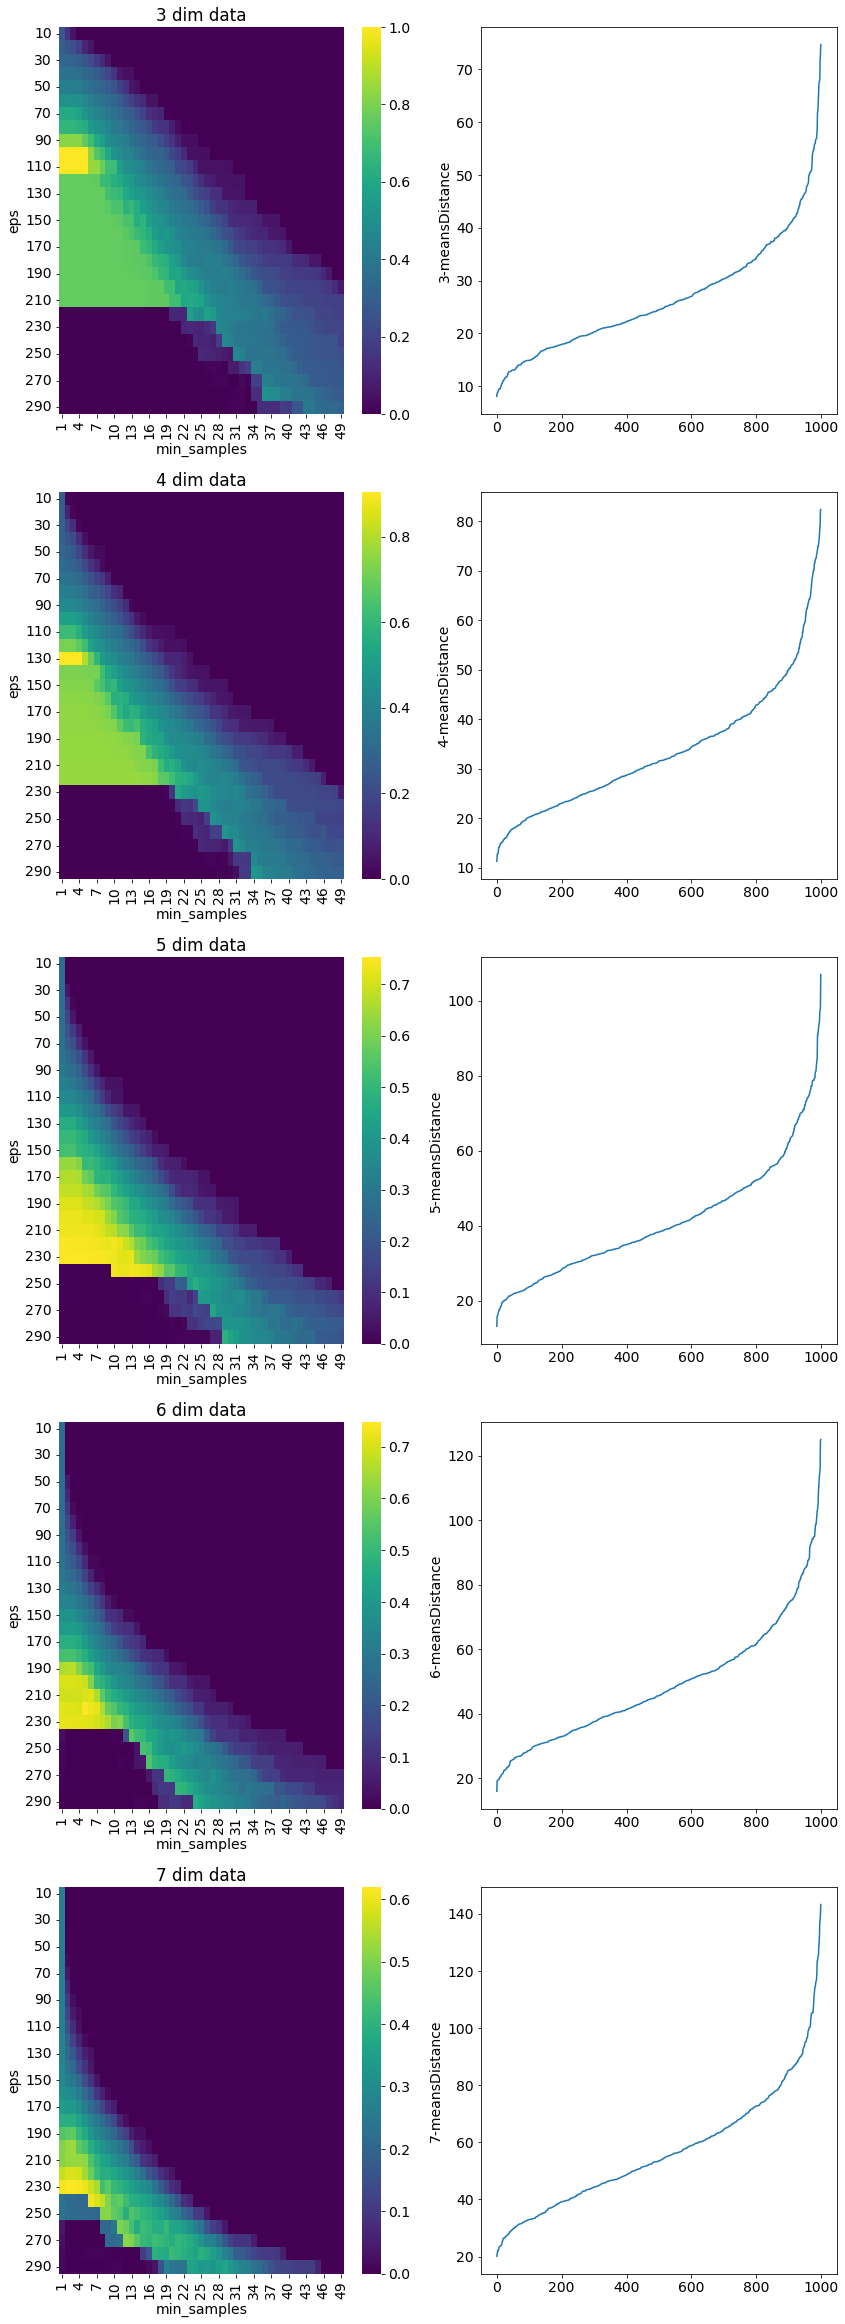

In [63]:
fig, axs = plt.subplots(len(extra_dim_range),2, figsize = (12, len(extra_dim_range)*6.5))

for extra_dim,ax in zip(extra_dim_range, axs) :
    df_dim = df_rot[df_rot["extra_dim"] == extra_dim]

    df_dim_plot = df_dim.pivot_table("nmi","eps","min_samples")
    sns.heatmap(df_dim_plot, cmap = 'viridis', ax = ax[0])
    
    ax[0].set_title(f"{3+extra_dim} dim data")
    
    neighbors = NearestNeighbors(n_neighbors=20)
    neighbors_fit = neighbors.fit(data)
    
    distances, indices = neighbors_fit.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,extra_dim+2]

    ax[1].plot(distances)
    ax[1].set_ylabel(f"{extra_dim+3}-meansDistance")
plt.tight_layout()
plt.show()

The epsilon parameter determines how far from a core point one should look for neighbouring points, while the minPts parameter descides what number of points is the minimum amount required to define a cluster. Hence, a point p is a core point if it has at least minPts within distance eps of it. 

Usually, as a rule of thumb, minPts is often set to 2 times the dimensionality of the data. Having a minPts parameter set to one makes no sence as every data point would be considered as a cluset on its own. In general minPts equal to three to achieve clustering with a different result than in hierarchical clustering. Often larger values are better for data that contains a lot of noise.

For the size of epsilon, one can create what is called a k-distance plot. For a given choice k of minPts, one plots the average distance between each point in the data set and its k nearest neighbours, sorted by acending value. The optimal value for epsilon will be the distnace where the plot has an elbow. This represents an optimization point where diminishing returns are no longer worth the additional cost. More clusters may increase the risk of overfitting. Below there have been created a k-distance plot for each of the dimensions tested with the value of nearest neighbours set to 20. One can see that the optimal value for epsilon increases with the added dimensions of noisy data. In the 3d-case the optimal value for epsilon in this case is about 40, while it in the 7d-case should be around 90. The results for the tuning of the paramteres are about the same for the unrotated and rotated data. The heatmaps with epsilon and minPts plotted agains each other does however show best accuracies on different values for epsilon for the same value of eps, which is a bit unexpected. This can be due to the extra amount of noise added, which disturbs the local similarities in the data, and hence, a larger epsilon is necessary. The more dimensions we add with noise, the more the epsilon needs to be increased for the DBSCAN to produce good results. However one did expect somewhat more correlation between the value for epsilon indicated by the k-distance plots and the performance of DBSCAN on our data. 